In [12]:
# !git clone https://github.com/alanqrwang/brainmorph.git
# %cd brainmorph
# !pip install -e .
import numpy as np
import nibabel as nib
import torchio as tio
from keymorph.viz_tools import imshow_img_and_points_3d, imshow_registration_3d

Cloning into 'brainmorph'...
remote: Enumerating objects: 1490, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (74/74), done.
fatal: write error: Disk quota exceeded2.81 MiB | 77.73 MiB/s
fatal: fetch-pack: invalid index-pack output
[Errno 2] No such file or directory: 'brainmorph'
/home/alw4013/brainmorph
Obtaining file:///home/alw4013/brainmorph
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keymorph: filename=keymorph-1.0.1-py3-none-any.whl size=62637 sha256=8fbbed4162c35cf2dae696c6bf0a72d258035addab8420ab4f6f4bf5fd42ce8d
  Stored in directory: /home/alw4013/.cache/pip/wheels/81/82/40/c0034f21e3735a350597d69b0ebf093f9949be316e830f49fa
Successfully built keymorph
  Attempting uninstall: keymorph
    Found existing installation: keymorph 1.0.0
    Can't uninstall 'keymorph'. No files were found to uninstall.
  R

First, specify the parameters of the model type you want to use:

In [2]:
NUM_KEYPOINTS = 512
VARIANT = 'S'

Run the registration command on provided example data:

In [11]:
%%bash -s "$NUM_KEYPOINTS" "$VARIANT"
python scripts/register.py \
    --num_keypoints $1 \
    --variant $2 \
    --weights_dir ./weights/ \
    --moving ./example_data/img_m/IXI_000001_0000.nii.gz \
    --fixed ./example_data/img_m/IXI_000002_0000.nii.gz \
    --moving_seg ./example_data/seg_m/IXI_000001_0000.nii.gz \
    --fixed_seg ./example_data/seg_m/IXI_000002_0000.nii.gz \
    --list_of_aligns rigid affine tps_1 \
    --list_of_metrics mse harddice \
    --save_eval_to_disk \
    --visualize \
    --download

Number of GPUs: 0

Model Summary
---------------------------------------------------------------
backbone.module.encoders.0.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.0.basic_module.SingleConv1.groupnorm.bias
backbone.module.encoders.0.basic_module.SingleConv1.conv.weight
backbone.module.encoders.0.basic_module.SingleConv2.groupnorm.weight
backbone.module.encoders.0.basic_module.SingleConv2.groupnorm.bias
backbone.module.encoders.0.basic_module.SingleConv2.conv.weight
backbone.module.encoders.1.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.1.basic_module.SingleConv1.groupnorm.bias
backbone.module.encoders.1.basic_module.SingleConv1.conv.weight
backbone.module.encoders.1.basic_module.SingleConv2.groupnorm.weight
backbone.module.encoders.1.basic_module.SingleConv2.groupnorm.bias
backbone.module.encoders.1.basic_module.SingleConv2.conv.weight
backbone.module.encoders.2.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.2.basic_m

Downloading...
From: https://drive.google.com/uc?id=14ig3UzF2awqTwkIA49BXBBz3lQQS4JCn
To: /home/alw4013/brainmorph/weights/foundation-numkey512-numlevels4.pth.tar
100%|██████████| 48.1M/48.1M [00:00<00:00, 189MB/s]



It took 0.1 minutes to download the model.

Loading checkpoint from ./weights/foundation-numkey512-numlevels4.pth.tar
Missing keys when loading checkpoint:  []



Running test: subject id 0->0, mod fixed->moving, aug rot0
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Figure(1600x1600)
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Figure(1600x1600)

Debugging info:
-> Time: 12.406212329864502
-> Alignment: rigid 
-> Max random params: (0, 0, 0, 0) 
-> Img shapes: torch.Size([1, 1, 256, 256, 256]), torch.Size([1, 1, 256, 256, 256])
-> Point shapes: torch.Size([1, 512, 3]), torch.Size([1, 512, 3])
-> Point weights: tensor([[3.6365e-03, 1.1971e-03, 1.8464e-03, 2.5245e-03, 1.3223e-03, 9.2329e-04,
         2.5663e-03, 2.5284e-03, 3.4474e-04, 1.5846e-03, 1.1735e-04, 6.0250e-0

Load the images and points which the above command generates:

In [3]:
moving_path = './example_data/img_m/IXI_000001_0000.nii.gz'
fixed_path = './example_data/img_m/IXI_000002_0000.nii.gz'
aligned_path = f'./register_output/eval_numkey{NUM_KEYPOINTS}_variant{VARIANT}/0_0_fixed_moving/img_a_0-fixed_0-moving-rot0-tps_1.npy'

points_m_path = f'register_output/eval_numkey{NUM_KEYPOINTS}_variant{VARIANT}/0_0_fixed_moving/points_m_0-moving-rot0.npy'
points_f_path = f'register_output/eval_numkey{NUM_KEYPOINTS}_variant{VARIANT}/0_0_fixed_moving/points_f_0-fixed.npy'
points_a_path = f'register_output/eval_numkey{NUM_KEYPOINTS}_variant{VARIANT}/0_0_fixed_moving/points_a_0-fixed_0-moving-rot0-tps_1.npy'
# points_a_path = f'register_output/eval_numkey{NUM_KEYPOINTS}_variant{VARIANT}/0_0_fixed_moving/points_weights_0-fixed_0-moving-rot0-rigid.npy'
points_weights_path = f'register_output/eval_numkey{NUM_KEYPOINTS}_variant{VARIANT}/0_0_fixed_moving/points_weights_0-fixed_0-moving-rot0-tps_1.npy'

moving = nib.load(moving_path).get_fdata()
fixed = nib.load(fixed_path).get_fdata()
aligned = np.load(aligned_path)[0]

points_m = np.load(points_m_path)
points_f = np.load(points_f_path)
points_a = np.load(points_a_path)
points_af = np.stack((points_a, points_f))
points_weights = np.load(points_weights_path)
print('Img shapes:', moving.shape, fixed.shape, aligned.shape)
print('Points shapes:', points_m.shape, points_f.shape, points_a.shape, points_weights.shape)

Img shapes: (256, 256, 150) (256, 256, 150) (256, 256, 256)
Points shapes: (512, 3) (512, 3) (512, 3) (512,)


Visualize the results. 

Note that the script always outputs registration results which are 1mm isotropic and cropped/padded to size 256x256x256. For the overlaying of keypoints in the visualizations to make sense, we will manually apply these transformations to the images:

Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

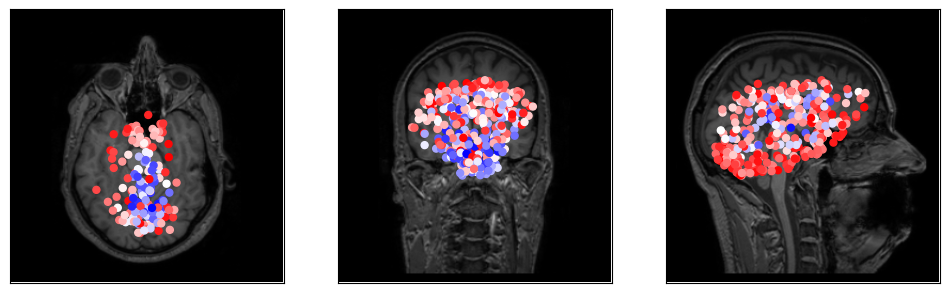

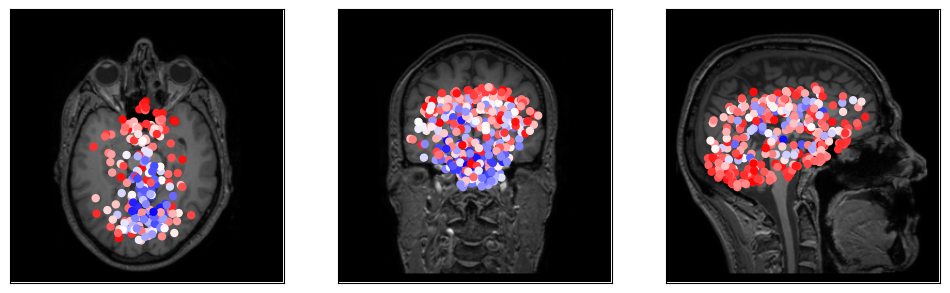

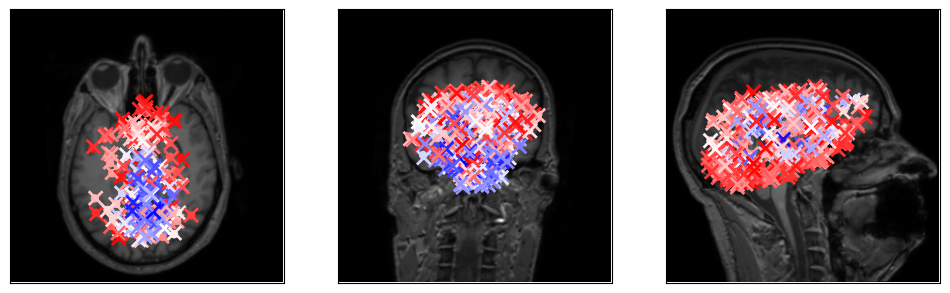

In [10]:
transform = tio.Compose(
            [
                tio.ToCanonical(),
                tio.Resample(1),
                tio.Resample("img"),
                tio.CropOrPad((256, 256, 256), padding_mode=0, include=("img",)),
                tio.CropOrPad((256, 256, 256), padding_mode=0, include=("seg",)),
            ],
            include=("img", "seg"),
        )
moving_subject = tio.Subject(img=tio.ScalarImage(moving_path))
fixed_subject = tio.Subject(img=tio.ScalarImage(fixed_path))

moving = transform(moving_subject)['img'].data[0]
fixed = transform(fixed_subject)['img'].data[0]

imshow_img_and_points_3d(moving, 
                         all_points=points_m, 
                        #  all_weights=points_weights, 
                         rotate_90_deg=1)
imshow_img_and_points_3d(fixed, 
                         all_points=points_f, 
                        #  all_weights=points_weights, 
                         rotate_90_deg=1)
imshow_img_and_points_3d(aligned, 
                         all_points=points_af, 
                        #  all_weights=points_weights, 
                         rotate_90_deg=1)

Passing in points_weights will visualize the keypoint weights via transparency:

Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

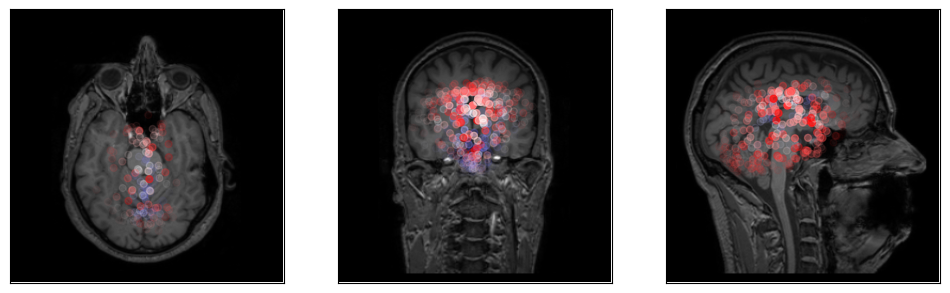

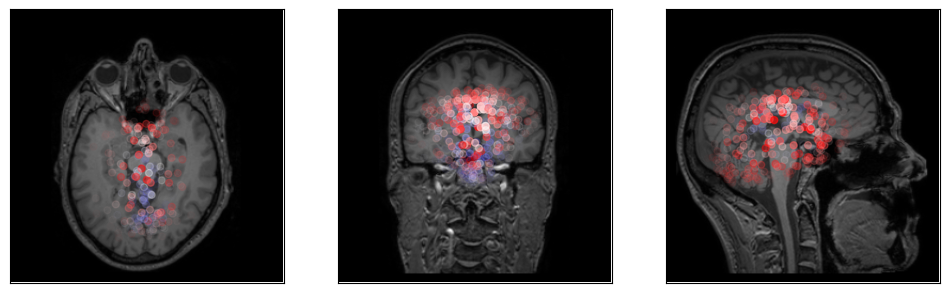

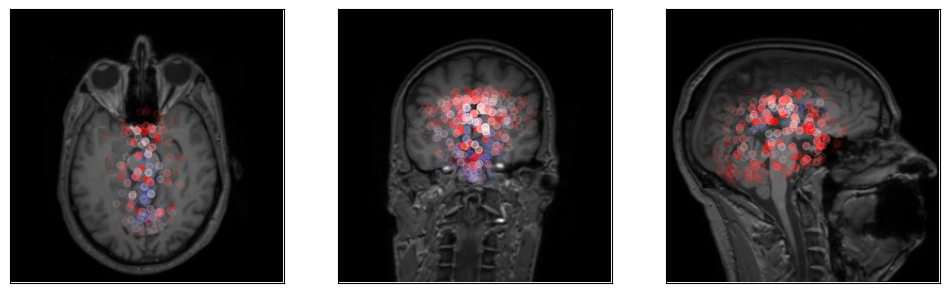

In [11]:
imshow_img_and_points_3d(moving, 
                         all_points=points_m, 
                         all_weights=points_weights, 
                         rotate_90_deg=1)
imshow_img_and_points_3d(fixed, 
                         all_points=points_f, 
                         all_weights=points_weights, 
                         rotate_90_deg=1)
imshow_img_and_points_3d(aligned, 
                         all_points=points_af, 
                         all_weights=points_weights, 
                         rotate_90_deg=1)

Or, visualize all the images at once using `imshow_registration_3d`:

Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates


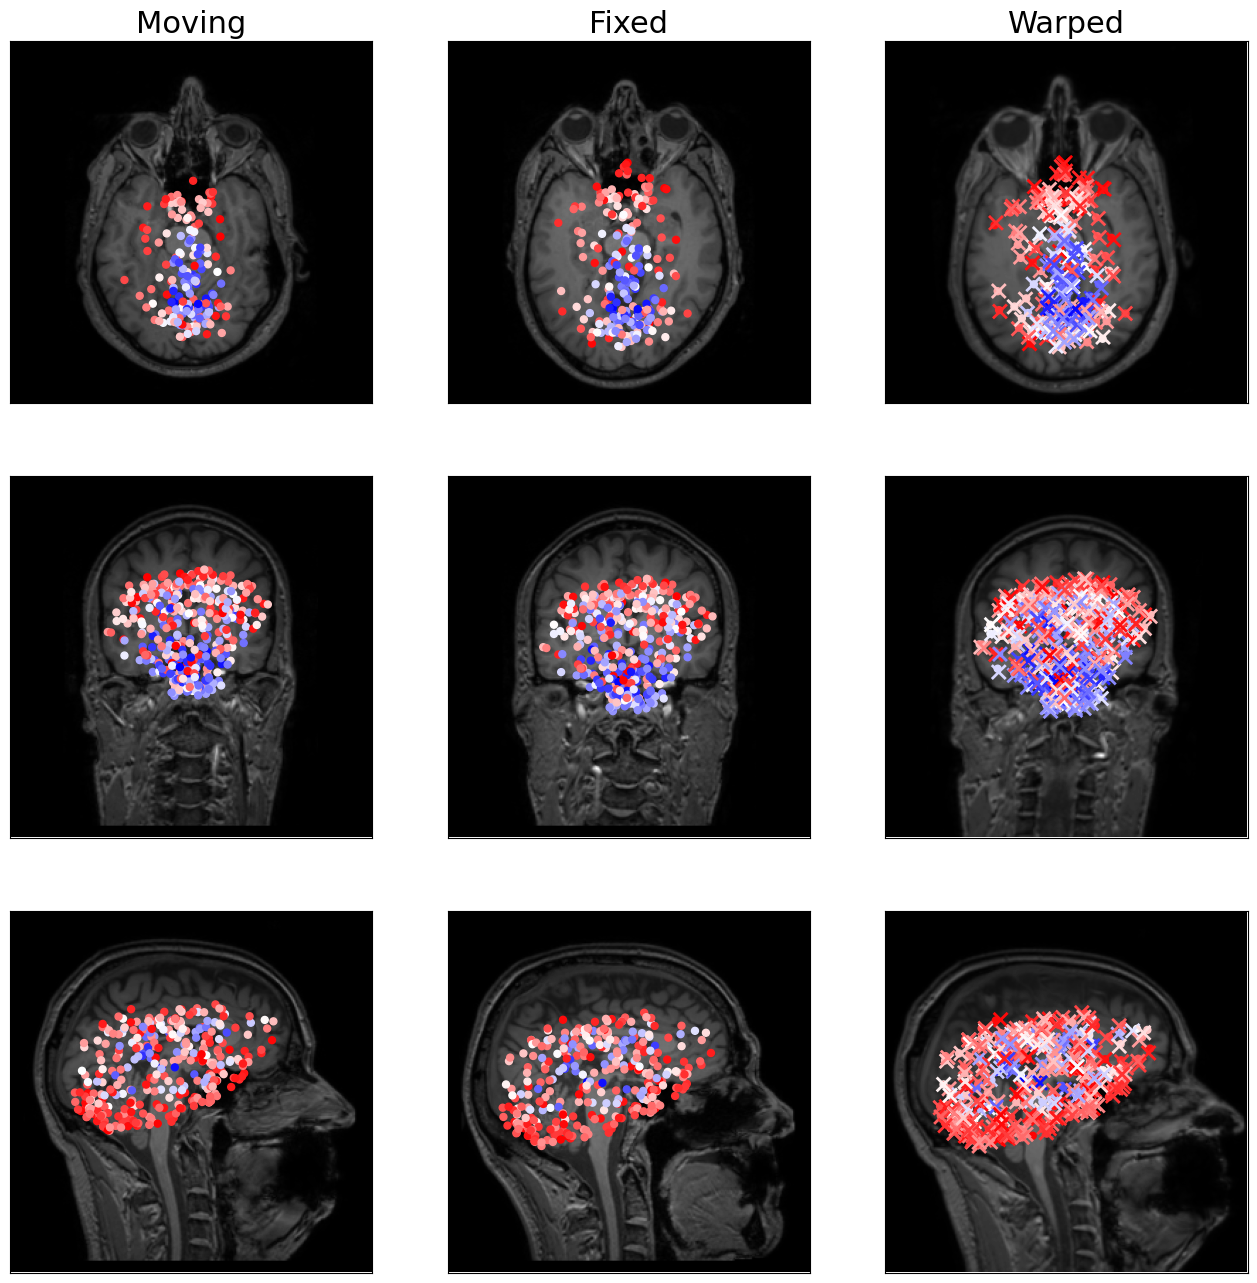

Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates


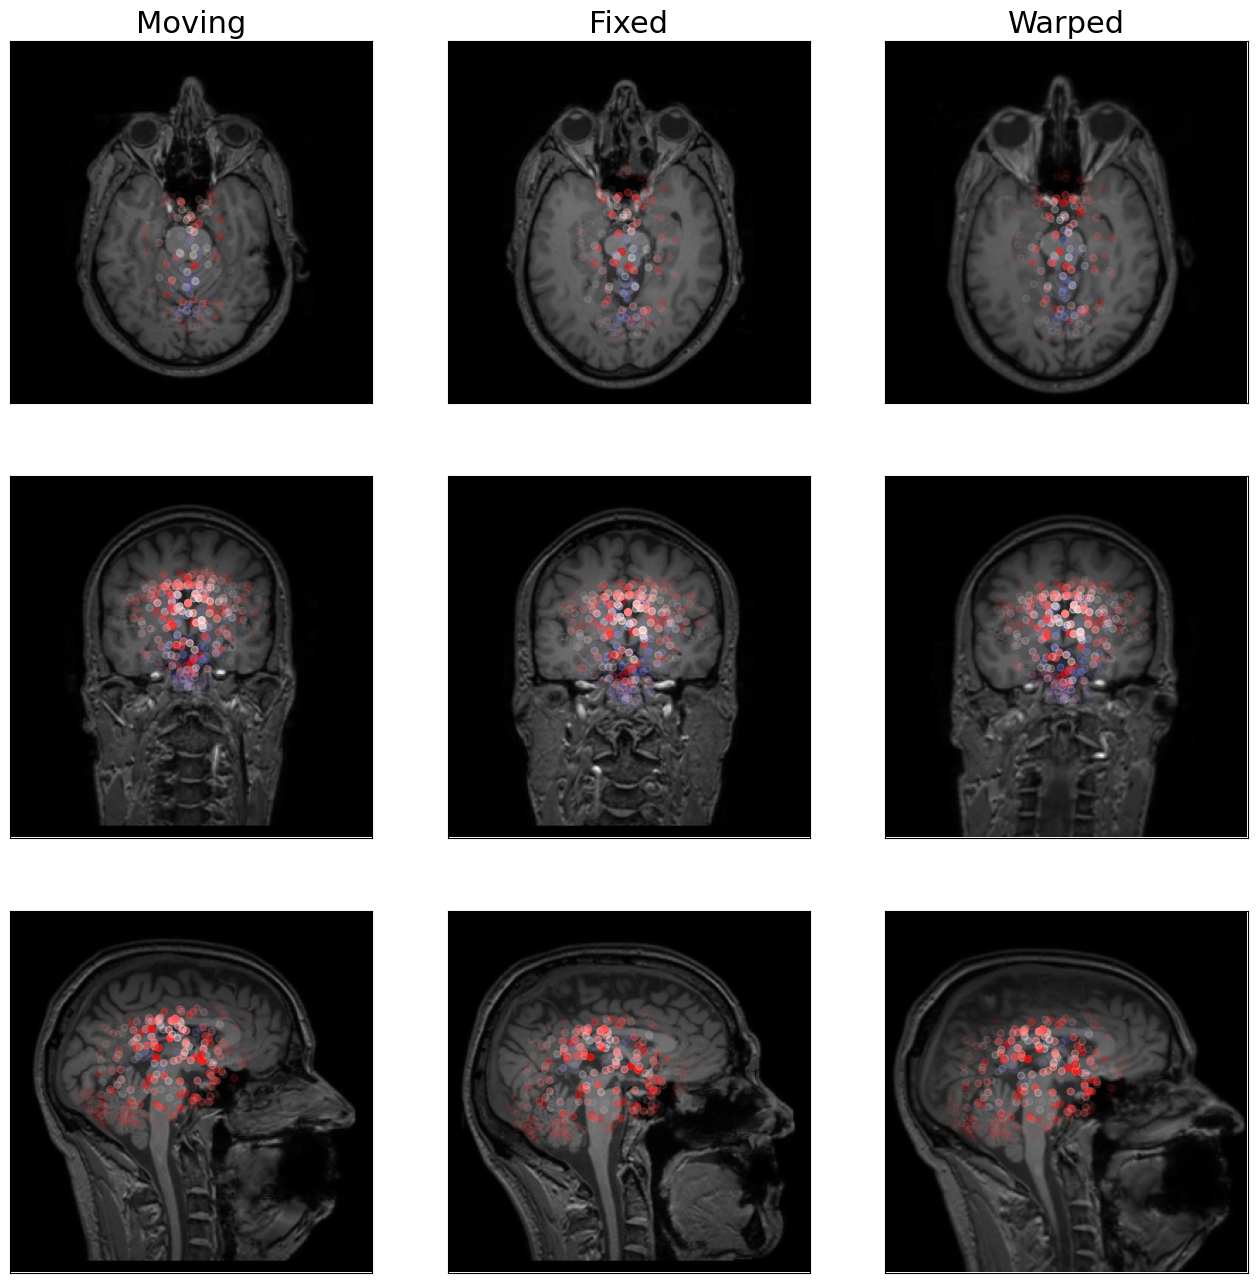

In [8]:
imshow_registration_3d(moving, fixed, aligned, points_m, points_f, points_a, rotate_90_deg=1)
imshow_registration_3d(moving, fixed, aligned, points_m, points_f, points_a, points_weights, rotate_90_deg=1)